In [406]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score


In [407]:
# =========== Load & Preprocess Data ===========
data_path = "../feature_engineering/processed_swim_features.csv"
df = pd.read_csv(data_path)

df_pre18 = df[df["Age_at_time_of_Swim"] < 18].copy()

events_to_remove = ["50 BR SCY", "50 BK SCY", "50 FL SCY", "100 IM SCY", "400 FR LCM"]
df_pre18 = df_pre18[~df_pre18["Event"].isin(events_to_remove)]


In [408]:
# =========== Feature Engineering ===========
swimmer_data = []
standard_events = df_pre18["Event"].unique()

for name, swimmer_df in df_pre18.groupby("Name"):
    specialty_1 = swimmer_df["Specialty_1"].iloc[0]
    specialty_2 = swimmer_df["Specialty_2"].iloc[0]
    career_length = swimmer_df["Career_Length"].iloc[0]

    swimmer_record = {
        "Name": name,
        "Career_Length": career_length,
        "Total_Swims": len(swimmer_df),
        "Num_Unique_Events": swimmer_df["Event"].nunique(),
        "Specialty_1": specialty_1,
        "Specialty_2": specialty_2
    }

    for event in standard_events:
        event_data = swimmer_df[swimmer_df["Event"] == event]
        if not event_data.empty:
            swimmer_record[f"Best_Spec_{event}"] = event_data["Specialization_Score"].max()
            swimmer_record[f"Mean_Cut_{event}"] = event_data["Time_cut_Score"].mean()
            swimmer_record[f"Swims_in_{event}"] = len(event_data) / swimmer_record["Total_Swims"]
        else:
            swimmer_record[f"Best_Spec_{event}"] = 0
            swimmer_record[f"Mean_Cut_{event}"] = 0
            swimmer_record[f"Swims_in_{event}"] = 0

    swimmer_data.append(swimmer_record)

swimmers_df = pd.DataFrame(swimmer_data)


In [409]:
# =========== Regression Target Preparation ===========
events_to_remove = ["800 Free", "400 Free"]
swimmers_df = swimmers_df[~swimmers_df["Specialty_1"].isin(events_to_remove)]
swimmers_df = swimmers_df[~swimmers_df["Specialty_2"].isin(events_to_remove)]

swimmers_df["Specialty_1"] = swimmers_df["Specialty_1"].fillna("Unknown")
swimmers_df["Specialty_2"] = swimmers_df["Specialty_2"].fillna("Unknown")



In [410]:
# =========== Prepare Target Variables ===========
# Get all unique specialty labels BEFORE filtering any events
# Initialize LabelEncoder and fit with all specialties found in the data AFTER filtering
specialty_1_values = swimmers_df["Specialty_1"].unique()
specialty_2_values = swimmers_df["Specialty_2"].unique()
all_specialties = np.unique(np.concatenate([specialty_1_values, specialty_2_values]))

# Create a new label encoder just for the specialties in our filtered dataset
label_encoder = LabelEncoder()
label_encoder.fit(all_specialties)

# Transform labels
swimmers_df["Specialty_1_Label"] = label_encoder.transform(swimmers_df["Specialty_1"])
swimmers_df["Specialty_2_Label"] = label_encoder.transform(swimmers_df["Specialty_2"])

# Print mapping for debugging
specialty_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("\n🔹 Specialty to Label Mapping:")
for specialty, label in specialty_mapping.items():
    print(f"  {specialty}: {label}")
    
    
# Verify final labels
print("Final Specialty_1 Labels:", np.unique(swimmers_df["Specialty_1_Label"]))
print("Final Specialty_2 Labels:", np.unique(swimmers_df["Specialty_2_Label"]))

# Define target columns
target_cols = ["Specialty_1_Label", "Specialty_2_Label"]


# Find missing labels in Specialty_1_Label
missing_labels_1 = set(np.arange(len(label_encoder.classes_))) - set(swimmers_df["Specialty_1_Label"].unique())

# If any labels are missing, add fake rows to ensure all labels are represented
if missing_labels_1:
    print(f"\n⚠️ Adding missing labels to Specialty_1_Label: {missing_labels_1}")
    for label in missing_labels_1:
        fake_row = swimmers_df.iloc[0].copy()  # Duplicate an existing row
        fake_row["Specialty_1_Label"] = label  # Assign missing label
        fake_row["Name"] = f"Fake_Swimmer_{label}"  # Ensure uniqueness
        swimmers_df = pd.concat([swimmers_df, pd.DataFrame([fake_row])], ignore_index=True)

# Re-check that all labels exist
print("\n✅ Final Specialty_1 Labels After Fix:", np.unique(swimmers_df["Specialty_1_Label"]))
print("✅ Final Specialty_2 Labels After Fix:", np.unique(swimmers_df["Specialty_2_Label"]))


🔹 Specialty to Label Mapping:
  100 Back: 0
  100 Breast: 1
  100 Fly: 2
  100 Free: 3
  1000 Free: 4
  1650 Free: 5
  200 Back: 6
  200 Breast: 7
  200 Fly: 8
  200 Free: 9
  200 IM: 10
  400 IM: 11
  50 Free: 12
  500 Free: 13
Final Specialty_1 Labels: [ 0  1  2  4  5  6  7  8  9 10 11 12]
Final Specialty_2 Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

⚠️ Adding missing labels to Specialty_1_Label: {3, 13}

✅ Final Specialty_1 Labels After Fix: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
✅ Final Specialty_2 Labels After Fix: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


In [411]:
# =========== Feature Selection ===========  
feature_cols = [col for col in swimmers_df.columns if col.startswith(("Best_Spec_", "Mean_Cut_", "Swims_in_"))]

# Select feature matrix (X) and target variables (y)
X = swimmers_df[feature_cols]
y = swimmers_df[target_cols]


In [412]:
# =========== Scale Features ===========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [413]:
# Count occurrences of each class in Specialty_1_Label and Specialty_2_Label
valid_labels_1 = y["Specialty_1_Label"].value_counts()
valid_labels_2 = y["Specialty_2_Label"].value_counts()

# Keep only labels that appear at least twice
valid_labels_1 = valid_labels_1[valid_labels_1 >= 2].index
valid_labels_2 = valid_labels_2[valid_labels_2 >= 2].index

# Filter out rows with rare classes
filtered_indices = y["Specialty_1_Label"].isin(valid_labels_1) & y["Specialty_2_Label"].isin(valid_labels_2)
X_filtered = X[filtered_indices]
y_filtered = y[filtered_indices]

In [414]:
# =========== Split Data for Evaluation ===========
# Now perform stratified train/test split on filtered data
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered["Specialty_1_Label"]
)

# Print the updated class distribution
print("\nSpecialty 1 Class Counts After Filtering:")
print(y_filtered["Specialty_1_Label"].value_counts())

print("\nSpecialty 2 Class Counts After Filtering:")
print(y_filtered["Specialty_2_Label"].value_counts())


Specialty 1 Class Counts After Filtering:
Specialty_1_Label
2     14
0     14
5     11
1     10
8     10
10     8
4      5
6      5
11     5
7      4
12     3
9      2
Name: count, dtype: int64

Specialty 2 Class Counts After Filtering:
Specialty_2_Label
7     10
3     10
8      9
6      9
2      8
4      8
13     8
0      6
1      5
12     5
11     5
10     4
5      4
Name: count, dtype: int64


In [415]:
# =========== Model Training ===========
# Ensure every label exists in y
expected_classes = np.arange(len(label_encoder.classes_))

for col in ["Specialty_1_Label", "Specialty_2_Label"]:
    missing_labels = set(expected_classes) - set(y[col].unique())

    if missing_labels:
        print(f"\n⚠️ Adding missing labels to {col}: {missing_labels}")
        for label in missing_labels:
            fake_row = swimmers_df.iloc[0].copy()  # Duplicate an existing row
            fake_row[col] = label  # Assign missing label
            fake_row["Name"] = f"Fake_Swimmer_{label}"  # Ensure uniqueness
            y = pd.concat([y, pd.DataFrame([fake_row[target_cols]])], ignore_index=True)

# Verify all labels exist in y
print("\n✅ Final Specialty_1 Labels After Fix:", np.unique(y["Specialty_1_Label"]))
print("✅ Final Specialty_2 Labels After Fix:", np.unique(y["Specialty_2_Label"]))


# We'll train separate models for each specialty to avoid issues with num_class
# First model for Specialty 1
clf1 = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    objective="multi:softmax",
    num_class=len(expected_classes),  # Explicitly set the number of classes
    random_state=42
)

# Second model for Specialty 2
clf2 = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    objective="multi:softmax",
    num_class=len(expected_classes),  # Ensure consistency
    random_state=42
)

# =========== Cross-validation ===========
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation for Specialty 1
y_pred_cv_1 = cross_val_predict(clf1, X_scaled, y["Specialty_1_Label"], cv=kf)

# Cross-validation for Specialty 2
y_pred_cv_2 = cross_val_predict(clf2, X_scaled, y["Specialty_2_Label"], cv=kf)

# Calculate metrics
accuracy_specialty_1 = accuracy_score(y["Specialty_1_Label"], y_pred_cv_1)
accuracy_specialty_2 = accuracy_score(y["Specialty_2_Label"], y_pred_cv_2)

f1_specialty_1 = f1_score(y["Specialty_1_Label"], y_pred_cv_1, average="weighted")
f1_specialty_2 = f1_score(y["Specialty_2_Label"], y_pred_cv_2, average="weighted")

# Print metrics from cross-validation
print("\nCross-Validation Metrics:")
print(f"Accuracy for Specialty 1: {accuracy_specialty_1:.4f}")
print(f"Accuracy for Specialty 2: {accuracy_specialty_2:.4f}")
print(f"F1-Score for Specialty 1: {f1_specialty_1:.4f}")
print(f"F1-Score for Specialty 2: {f1_specialty_2:.4f}")



✅ Final Specialty_1 Labels After Fix: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
✅ Final Specialty_2 Labels After Fix: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11 12], got [ 0  1  2  4  5  6  7  8  9 10 11 12 13]

In [317]:
# =========== Model Training ===========
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define expected class labels
expected_classes = np.arange(len(all_specialties))

# Initialize MultiOutputClassifier with XGBClassifier
clf = MultiOutputClassifier(XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    objective="multi:softmax",
    num_class=len(expected_classes),
    random_state=42
), n_jobs=-1)  # Use multiple cores for efficiency

clf.fit(X_scaled, y)

# Perform cross-validation
y_pred_cv = cross_val_predict(clf, X_scaled, y, cv=kf)

# Convert predictions to DataFrame
y_pred_df = pd.DataFrame(y_pred_cv, columns=["Predicted_Specialty_1_Label", "Predicted_Specialty_2_Label"])
y_true_df = pd.DataFrame(y, columns=["Specialty_1_Label", "Specialty_2_Label"])

# Compute accuracy for each specialty separately
accuracy_specialty_1 = accuracy_score(y_true_df["Specialty_1_Label"], y_pred_df["Predicted_Specialty_1_Label"])
accuracy_specialty_2 = accuracy_score(y_true_df["Specialty_2_Label"], y_pred_df["Predicted_Specialty_2_Label"])

# Compute F1-score for each specialty
f1_specialty_1 = f1_score(y_true_df["Specialty_1_Label"], y_pred_df["Predicted_Specialty_1_Label"], average="weighted")
f1_specialty_2 = f1_score(y_true_df["Specialty_2_Label"], y_pred_df["Predicted_Specialty_2_Label"], average="weighted")

# Print results
print(f"Accuracy for Specialty 1: {accuracy_specialty_1:.4f}")
print(f"Accuracy for Specialty 2: {accuracy_specialty_2:.4f}")
print(f"F1-Score for Specialty 1: {f1_specialty_1:.4f}")
print(f"F1-Score for Specialty 2: {f1_specialty_2:.4f}")


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [ 0  1  2  3  4  5  6  7  8  9 10 11], got [ 0  1  2  4  5  6  7  8  9 10 11 12]

In [189]:
# =========== Model Evaluation ===========
y_pred = clf.predict(X_test)

print(f"Hamming Loss: {hamming_loss(y_test, y_pred):.4f}")
print(f"F1 Score (Micro): {f1_score(y_test, y_pred, average='micro'):.4f}")
print(f"F1 Score (Macro): {f1_score(y_test, y_pred, average='macro'):.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


Hamming Loss: 0.1429
F1 Score (Micro): 0.2963
F1 Score (Macro): 0.2323
Classification Report:
              precision    recall  f1-score   support

    100 Back       0.67      0.40      0.50         5
  100 Breast       0.50      0.33      0.40         3
     100 Fly       0.33      0.25      0.29         4
    100 Free       0.00      0.00      0.00         1
   1000 Free       0.50      0.50      0.50         2
   1650 Free       0.00      0.00      0.00         2
    200 Back       0.33      0.50      0.40         2
  200 Breast       1.00      0.50      0.67         2
     200 Fly       1.00      0.33      0.50         3
    200 Free       0.00      0.00      0.00         3
      200 IM       0.00      0.00      0.00         4
      400 IM       0.00      0.00      0.00         3
     50 Free       0.00      0.00      0.00         2
    500 Free       0.00      0.00      0.00         1

   micro avg       0.47      0.22      0.30        37
   macro avg       0.31      0.20      0

/opt/anaconda3/envs/cs229_project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/cs229_project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


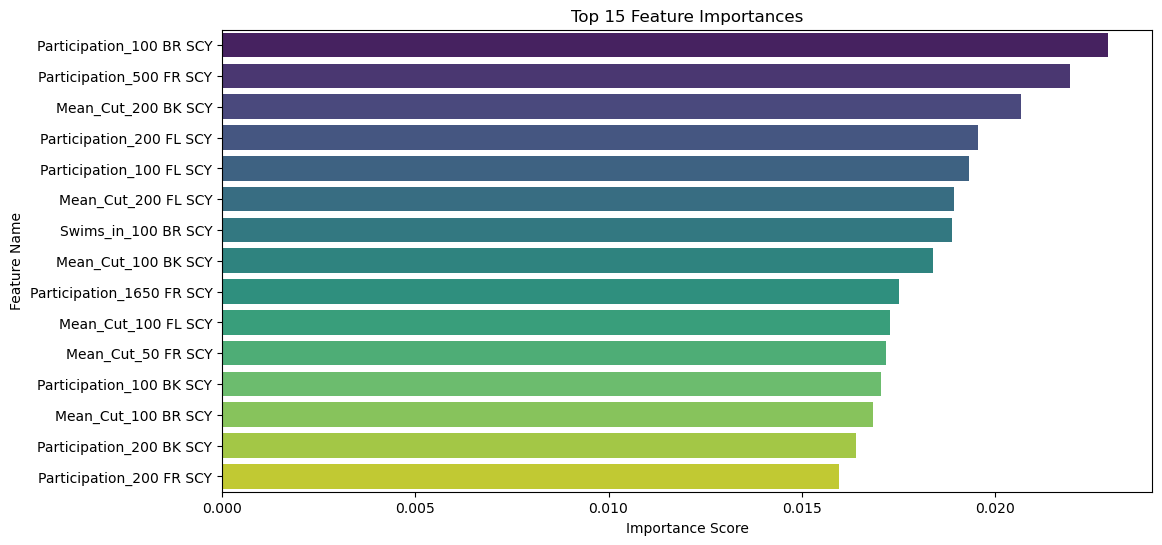

In [190]:
# =========== Feature Importance Visualization ===========
# Extract feature importances from RandomForestClassifier inside MultiOutputClassifier
importances = np.mean([est.feature_importances_ for est in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
top_features = [features[i] for i in indices[:15]]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices[:15]], y=top_features, hue=top_features, legend=False, palette="viridis")
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()